<a href="https://colab.research.google.com/github/alexgaarciia/SyntheticTrafficRouting/blob/main/path_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [67]:
# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# If in Google Colab, clone the repository
if IN_COLAB:
    !git clone https://github.com/alexgaarciia/SyntheticTrafficRouting.git
    import os
    os.chdir('SyntheticTrafficRouting/')
    print("Repository cloned!")
else:
    print("Not in Google Colab, skipping repository clone.")

Not in Google Colab, skipping repository clone.


In [68]:
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from functions import rescale_demand

## Load datasets

In [69]:
combined_data = pd.read_csv("real_data.csv", sep=",")
synthetic_data_sdv = pd.read_csv("synthetic_data_sdv.csv", sep=",")
synthetic_data_gan = pd.read_csv("synthetic_data_gan.csv", sep=",")

## Rescale demand values

In [70]:
# Mbits/s to Gbits/s
combined_data["demand_value"] = combined_data["demand_value"]/1000
synthetic_data_gan["demand_value"] = synthetic_data_gan["demand_value"]/1000
synthetic_data_sdv["demand_value"] = synthetic_data_sdv["demand_value"]/1000

# Scale datasets to reflect actual traffic demand
growth_factor = (1 + 0.45) ** (2025 - 2004)
combined_data = rescale_demand(combined_data, growth_factor)
synthetic_data_gan = rescale_demand(synthetic_data_gan, growth_factor)
synthetic_data_sdv = rescale_demand(synthetic_data_sdv, growth_factor)

## Sum Demand Values for Each Source-Target Pair

In [71]:
# Sum demand values for each source-target pair
sum_demand_real = combined_data.groupby(['source', 'target'], as_index=False)['demand_value'].sum()
sum_demand_gan = synthetic_data_gan.groupby(['source', 'target'], as_index=False)['demand_value'].sum()
sum_demand_sdv = synthetic_data_sdv.groupby(['source', 'target'], as_index=False)['demand_value'].sum()

In [72]:
# Filter out rows where source equals target
sum_demand_gan = sum_demand_gan[sum_demand_gan["source"] != sum_demand_gan["target"]]
sum_demand_sdv = sum_demand_sdv[sum_demand_sdv["source"] != sum_demand_sdv["target"]]

## Build graph 

In [73]:
def create_graph(data):
    G = nx.Graph()
    for index, row in data.iterrows():
        G.add_edge(row['source'], row['target'], weight=row['demand_value'])
    return G

In [74]:
def plot_graph(G):
    # Define layout for the graph (spring layout for better spacing)
    pos = nx.spring_layout(G, seed=42)

    # Draw nodes and edges
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue', edgecolors='k')
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7, edge_color='gray')

    # Add labels for nodes
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

    # Add edge weights as labels
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='red')

    # Customize plot appearance
    plt.title("Network Graph with Shortest Path Demand Values", fontsize=16)
    plt.axis('off')
    plt.show()  
    

## Find the shortest path from a source to a destination

In [75]:
def calculate_shortest_path_load(G, source, target):
    # Find the shortest path using Dijkstra's algorithm (based on demand values)
    path = nx.shortest_path(G, source=source, target=target, weight='weight')
    total_load = sum(G[u][v]['weight'] for u, v in zip(path[:-1], path[1:]))
    return path, total_load

## Testing

In [76]:
# Create graphs
G_real = create_graph(sum_demand_real)
G_gan = create_graph(sum_demand_gan)
G_sdv = create_graph(sum_demand_sdv)

In [77]:
# Define the "From-To" pairs
from_to_pairs = [
    ("ATLAM5", "ATLAng"),
    ("DNVRng", "WASHng"),
    ("HSTNng", "NYCMng"),
    ("IPLSng", "STTLng"),
    ("KSCYng", "SNVAng"),
    ("LOSAng", "ATLAng"),
]

# Create an empty list to store results
path_load_data = []

# Calculate shortest paths and link loads for each pair and dataset type
for source, target in from_to_pairs:
    for graph_name, graph in [("Real Data", G_real), ("GAN Synthetic Data", G_gan), ("SDV Synthetic Data", G_sdv)]:
        try:
            path, total_load = calculate_shortest_path_load(graph, source, target)
            path_load_data.append({
                "Source-Destination Pair": source + "-" + target,
                "Path": "-".join(path),
                "Total Load": total_load,
                "Dataset": graph_name
            })
        except nx.NetworkXNoPath:
            path_load_data.append({
                "Source-Destination Pair": source + "-" + target,
                "Path": "No Path",
                "Total Load": None,
                "Dataset": graph_name
            })

# Convert the list of dictionaries to a DataFrame
path_load_df = pd.DataFrame(path_load_data)

In [78]:
print(path_load_df)

   Source-Destination Pair                         Path   Total Load  \
0            ATLAM5-ATLAng                ATLAM5-ATLAng    71.409142   
1            ATLAM5-ATLAng                ATLAM5-ATLAng     4.717552   
2            ATLAM5-ATLAng                ATLAM5-ATLAng   109.013672   
3            DNVRng-WASHng         DNVRng-ATLAM5-WASHng   274.534949   
4            DNVRng-WASHng         DNVRng-ATLAM5-WASHng   190.897362   
5            DNVRng-WASHng         DNVRng-ATLAM5-WASHng  2241.058846   
6            HSTNng-NYCMng  HSTNng-SNVAng-ATLAM5-NYCMng   464.632235   
7            HSTNng-NYCMng         HSTNng-ATLAM5-NYCMng    16.524972   
8            HSTNng-NYCMng         HSTNng-ATLAM5-NYCMng   577.310531   
9            IPLSng-STTLng         IPLSng-ATLAM5-STTLng   133.241572   
10           IPLSng-STTLng         IPLSng-ATLAM5-STTLng    33.547566   
11           IPLSng-STTLng         IPLSng-ATLAM5-STTLng   555.256769   
12           KSCYng-SNVAng         KSCYng-ATLAM5-SNVAng    43.93

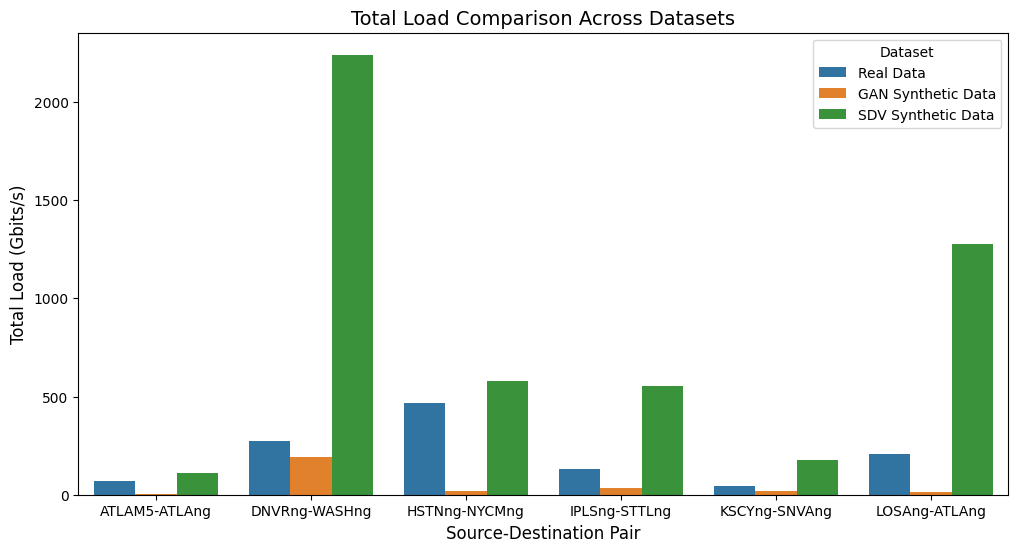

In [79]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=path_load_df,
    x="Source-Destination Pair",
    y="Total Load",
    hue="Dataset")

plt.xlabel("Source-Destination Pair", fontsize=12)
plt.ylabel("Total Load (Gbits/s)", fontsize=12)
plt.title("Total Load Comparison Across Datasets", fontsize=14)
plt.show()